<a href="https://colab.research.google.com/github/r-o-h-a-n-2004/feature-extraction-and-fine-tuning-using-resnet/blob/main/feature_extraction_and_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Load the CIFAR-10 dataset (10 classes)
(train_ds, val_ds), info = tfds.load(
    'cifar10',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True
)

# Constants
IMG_SIZE = (224, 224)  # ResNet50 expects 224x224 images
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
NUM_CLASSES = 10  # CIFAR-10 has 10 classes

# Get class names
class_names = info.features['label'].names
print("Class names:", class_names)

# Data preprocessing and augmentation
def preprocess_image(image, label):
    # Resize and normalize images
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

def augment(image, label):
    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)
    # Random rotation
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    # Random brightness and contrast
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

# Prepare datasets
train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = val_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)


Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Training the top layers...
Epoch 1/10
1250/1250 [==============================] - 115s 90ms/step - loss: 0.9660 - accuracy: 0.6548 - val_loss: 0.4748 - val_accuracy: 0.8428
Epoch 2/10
1250/1250 [==============================] - 108s 86ms/step - loss: 0.7677 - accuracy: 0.7366 - val_loss: 0.4403 - val_accuracy: 0.8583
Epoch 3/10
1250/1250 [==============================] - 109s 87ms/step - loss: 0.7102 - accuracy: 0.7543 - val_loss: 0.4027 - val_accuracy: 0.8580
Epoch 4/10
1250/1250 [==============================] - 113s 90ms/step - loss: 0.6758 - accuracy: 0.7664 - val_loss: 0.4083 - val_accuracy: 0.8637
Epoch 5/10
1250/1250 [==============================] - 120s 96ms/step - loss: 0.6489 - accuracy: 0.7770 - val_loss: 0.4251 - val_accuracy: 0.8627
Epoch 6/10
1250/1250 [==============================] - 120s 96ms/step - loss: 0.6280 - accuracy: 0.7823 - val_loss: 0.3702 - val_accuracy: 0.8802
Epoch 7/10
1250/1250 [==============================] - 120s 95ms/step - loss: 0.6089 - acc

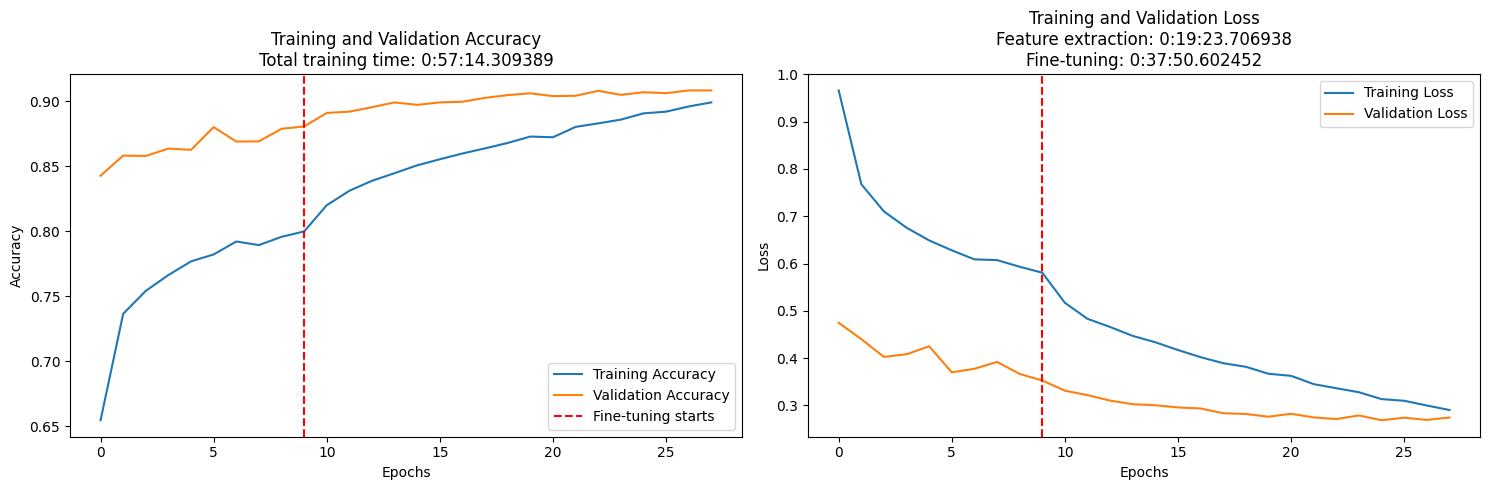

In [8]:
import time
from datetime import timedelta

# ... [previous imports remain the same] ...

# Load ResNet50 base model (excluding top layers)
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze the entire base model initially
base_model.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = models.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model - Feature Extraction Phase
print("Training the top layers...")
start_time = time.time()
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping]
)
feature_extraction_time = time.time() - start_time
print(f"Feature extraction training completed in: {timedelta(seconds=feature_extraction_time)}")

# Fine-tuning phase: Unfreeze the last convolutional block
base_model.trainable = True
for layer in base_model.layers:
    if 'conv5_block3' not in layer.name:
        layer.trainable = False
    else:
        print(f"Unfreezing layer: {layer.name}")

# Keep BatchNorm layers in inference mode
for layer in base_model.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model - Fine-tuning Phase
print("\nFine-tuning the last convolutional block...")
start_time = time.time()
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    initial_epoch=history.epoch[-1] + 1,
    callbacks=[early_stopping]
)
fine_tuning_time = time.time() - start_time
print(f"Fine-tuning completed in: {timedelta(seconds=fine_tuning_time)}")

# Calculate total training time
total_time = feature_extraction_time + fine_tuning_time
print(f"\nTotal training time: {timedelta(seconds=total_time)}")
print(f"Feature extraction: {timedelta(seconds=feature_extraction_time)} ({feature_extraction_time/total_time:.1%})")
print(f"Fine-tuning: {timedelta(seconds=fine_tuning_time)} ({fine_tuning_time/total_time:.1%})")

# Evaluate the model
start_time = time.time()
loss, accuracy = model.evaluate(val_ds)
eval_time = time.time() - start_time
print(f"\nEvaluation completed in: {timedelta(seconds=eval_time)}")
print(f"Final Validation Accuracy: {accuracy*100:.2f}%")

# Combine the history objects
total_history = {}
for key in history.history.keys():
    total_history[key] = history.history[key] + history_fine.history[key]

# Add timing information to the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(total_history['accuracy'], label='Training Accuracy')
ax1.plot(total_history['val_accuracy'], label='Validation Accuracy')
ax1.axvline(len(history.history['accuracy'])-1, color='r', linestyle='--', label='Fine-tuning starts')
ax1.set_title(f'Training and Validation Accuracy\nTotal training time: {timedelta(seconds=total_time)}')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(total_history['loss'], label='Training Loss')
ax2.plot(total_history['val_loss'], label='Validation Loss')
ax2.axvline(len(history.history['loss'])-1, color='r', linestyle='--')
ax2.set_title(f'Training and Validation Loss\nFeature extraction: {timedelta(seconds=feature_extraction_time)}\nFine-tuning: {timedelta(seconds=fine_tuning_time)}')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

# ... [rest of your code remains the same] ...